# Rubric 1: 
### Are all required files submitted?

This submission includes a model.py file, drive.py, udacityModel12.h5 a writeup report and video.mp4.

* Code : all the code that is requred to load the data and train a successful deep network is in this notebook.
* drive.py : drive.py has been modified a little, since many iterations of improvements were performed since the beginning.
* modle.h5 : the file used to make the final video of car driving autonomously uses _ udacityModel12.h5.
* video.mp4 : video file can be found as _ autonomousDriving.mp4 _

# Rubric 2: 
### Is the code functional?

This code is fully functional and final successfully trained deep network is produced by code in this repository.


# Rubric 3:

### Is the code usable and readable?

I have commented whole code as needed.

#### Generators:
Generators turned out to be essential for training this model, because I didn't have access to a machine with lots of main memory or processing power. So, generating small chunks of data and loading only that much proved to be absolute necessity.

Not only in this project, I think generators are very useful tool to train models on large data.

# Rubric 4: 

### Has an appropriate model architecture been employed for the task?

I have tried to closely follow architecutre of NVidia model.

Before settling on NVidia model, I experimented with different architectures and colour spaces. Small trainnig time was important because I have a normal computer (with i7 processor and 8 GB RAM, without any graphics card), which caused me to resize input images to neural network to (200, 66) rather than the default (320, 160).

# Rubric 5:

### Has an attempt been made to reduce overfitting of the model?

I experimented with drop out layers and l2 regularizers, and in the end decided to use l2 regularizers only.

Training and validation set have been divided into 80% and 20% ratio.

# Rubric 6:

### Have the model parameters been tuned appropriately?

I have used Adam optimizer, hence learning parameter was chosen automatically.

# Rubric 7:

### Is the training data chosen appropriately?

Initially I decided to collect the data on my own. I started the simulator with fastest graphics rendering and lowest resolution (due to processing power limitations). I recorded the data for one round track 1 and trained the model, however, my car was doing really bad on taking turns. I decided to modify the data.

Later I started to use images from left and right camera as well. This caused my data set to grow 3 times the original (nice), and later I used flipping all 3 camera images, that caused my data to grow 6 times (very nice).

#### Data Flattening
After experimenting a litte with training, facing the problems at turning and reading Udacity forums, I came to understand that having a lot of samples of 0 steering angle ( or close to 0) was the reason the car was not taking turns well in simulator. I decided to reduce these kind of samples where were making the model biased towards driving straight.

The data set was distributed into 25 bins. Average number of samples per bins was calculated, and this number is taken as maximum each bin can have after processing. A rejection probability is computed as (1 - samplesInBin/AverageSamplesPerBin), and if a bin has less than average samples, then its rejection probability is set to 0 (i.e. keep all the samples in the bin). This rejection probability is used to reject surplus of samples, where were making the model biased.

# Rubric 8:

### Is the solution design documented?

# Rubric 9:

### Is the model architecture documented?

# Rubric 10:

### Is the creation of the training dataset and training process documented?

# Rubric 11:

### Is the car able to navigate correctly on test data?

In [2]:
import argparse
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Lambda, Dense, Flatten, Cropping2D, Convolution2D, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, Callback

import matplotlib.pyplot as plt

from myModels import *

Using TensorFlow backend.


### Helping Functions:

In [2]:
def getCsvLines(path):
    # read image paths and corresponding steering angles
    samples =[]
    firstLine = True
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        for i_line in reader:
            if firstLine==True:
                firstLine=False
            else:
                samples.append(i_line)
    return samples


def prepareTrainingData(path, useAllCameraImages=False, cameraCorrectionFactor = 0.15):
    imagePaths = []
    angles = []
    camera_angle_factor = [0,+1,-1]

    samplesLines = getCsvLines(path)
    if useAllCameraImages:
        imagesToUse = 3
    else:
        imagesToUse = 1

    for i_line in samplesLines:

        for i in range(imagesToUse):
            i_imagePath = i_line[i].split('/')[-1]
            imagePaths.append(i_imagePath)
            i_angle = float(i_line[3])+cameraCorrectionFactor*camera_angle_factor[i]
            angles.append(i_angle)        

    samples = list(zip(imagePaths, angles))
    return samples

def generator(samples, dataDir, batch_size=32,color_space='RGB', useFlipImages=False):
    num_samples = len(samples)
    baseDir = dataDir +'/IMG/'

    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images, angles = [], []
            for i_imagePath, i_angle in batch_samples:
                
                #images.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
                i_image = cv2.imread(baseDir+i_imagePath)
                #print(name)
                # crop the image
                i_image = i_image[51:141,:]
                
                # resize the image to 66 by 200
                i_image = cv2.resize(i_image, (200, 66))
                
                if color_space == 'RGB':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2RGB)
                elif color_space == 'HSV':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2HSV)
                elif color_space == 'LUV':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2LUV)
                elif color_space == 'HLS':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2HLS)
                elif color_space == 'YUV':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2YUV)
                elif color_space == 'YCrCb':
                    i_image = cv2.cvtColor(i_image, cv2.COLOR_BGR2YCrCb)
                        
                images.append(i_image)
                # add steering angle according to which camera it came from i.e. center, left or right
                angles.append(i_angle)
                
                if useFlipImages:
                    # add flipped images also
                    images.append(np.fliplr(i_image))
                    angles.append(-i_angle)


                # trim image to only see section with road
                X_train = np.array(images)
                y_train = np.array(angles)

                #print(X_train.size,y_train.size)
                yield sklearn.utils.shuffle(X_train, y_train)


### Training Models

In [3]:
# replicate nVidia pipeline
def createNVidiaModel(activation_function='elu', dropOutRate=0.0, inputImageShape=(66,200,3)):

    model = Sequential()

    # add normalization and cropping layers
    #model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape = (160,320,3)))

    # resize images to 66*200
    #    model.add(Lambda(lambda x:
    # normalise the input images so that input values to NN varies from -0.5 to 0.5    
    model.add(Lambda(lambda x: x/255-0.5, input_shape = inputImageShape))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation=activation_function))
    model.add(Dropout(dropOutRate))    
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function))
    model.add(Dropout(dropOutRate))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    return model


def smallerNVidiaModel(activation_function='elu', dropOutRate=0.0, inputImageShape=(66,200,3)):

    model = Sequential()

    # add normalization and cropping layers
    #model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape = (160,320,3)))

    # resize images to 66*200
    #    model.add(Lambda(lambda x:
    # normalise the input images so that input values to NN varies from -0.5 to 0.5    
    model.add(Lambda(lambda x: x/255-0.5, input_shape = inputImageShape))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))    
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation=activation_function, W_regularizer=l2(0.001)))
    model.add(Dropout(dropOutRate))
    model.add(Flatten())
#    model.add(Dense(1164))
    model.add(Dense(100, W_regularizer=l2(0.001)))
    model.add(Dense(50, W_regularizer=l2(0.001)))
    model.add(Dense(10, W_regularizer=l2(0.001)))
    model.add(Dense(1))

    return model


## Training the model

### Load the data

In [4]:
#    dataDir = './fastDriveData/'
#dataDir = './myCapturedData/'
#dataDir = './dataWithKeyboard/'
dataDir = './data/'

samples = prepareTrainingData(dataDir+'/driving_log.csv', useAllCameraImages=True)

print(len(samples))
print(samples[0])

24108
('center_2016_12_01_13_30_48_287.jpg', 0.0)


## Visualize the data

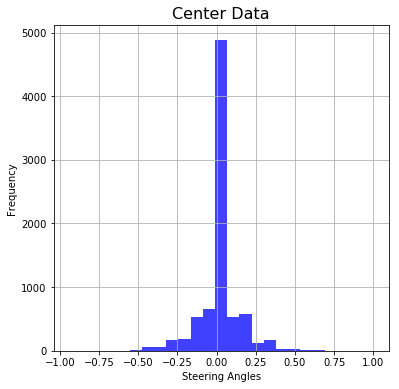

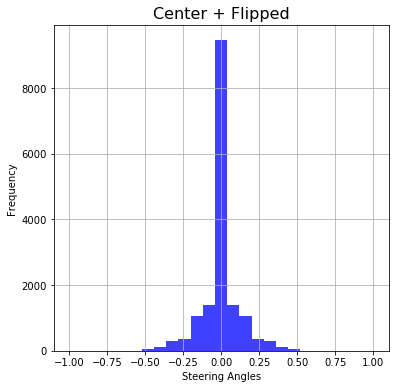

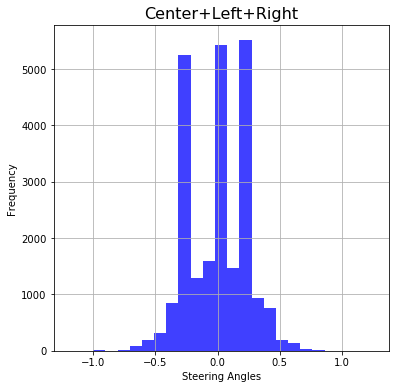

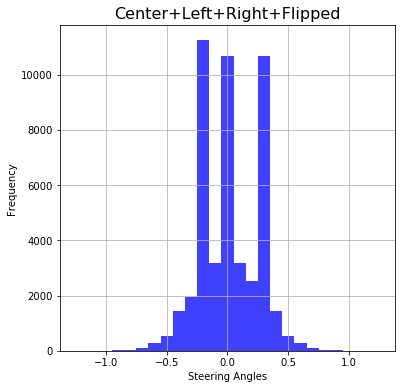

Average number of data points per bin :1928.64


In [5]:
filePath = dataDir+'/driving_log.csv'
lines=getCsvLines(filePath) 
steeringAngles=[]
bins = 25

originalData = []
originalFlippedData = []
originalCLRData = []
originalFlippedCLRData = []
camera_angle_factor = [0,+1,-1]
camera_correction_factor = 0.25

for i_line in lines:        
    # use images from all cameras, center, left and right
    i_angleCenter = float(i_line[3])
    
    originalData.append(i_angleCenter)
    
    for i in range(3):
        #print(i_line)
        # add steering angle according to which camera it came from i.e. center, left or right
        i_angle=i_angleCenter+camera_correction_factor*camera_angle_factor[i]
        
        originalCLRData.append(i_angle)
        originalFlippedCLRData.extend([i_angle,-i_angle])
originalFlippedData.extend(originalData)
originalFlippedData.extend([-i for i in originalData])

#originalFlippedCLRData.extend([i for i in originalCLRData])
#originalFlippedCLRData.extend([-i for i in originalCLRData])
#convert images and steering angles into numpy arrays

for steeringAngles, title in zip([originalData, originalFlippedData, originalCLRData, originalFlippedCLRData],['Center Data', 'Center + Flipped', 'Center+Left+Right', 'Center+Left+Right+Flipped']):
    
    y_train = np.array(steeringAngles)
    plt.figure(figsize=(6,6))
    plt.hist(y_train, bins, facecolor='b', alpha=0.75)
    plt.title(title, fontsize=16)
    plt.xlabel('Steering Angles')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

print('Average number of data points per bin :{}'.format(len(originalFlippedCLRData)/bins))

## Data Normalization

In [6]:
anglesOnly = [i[1] for i in samples]
print(len(anglesOnly))
dataHistogram, numBins = np.histogram(anglesOnly, bins)

print('numBins {}, length = {}'.format( numBins, len(numBins)))
print(dataHistogram, len(dataHistogram))

24108
numBins [-1.0926954  -1.00298758 -0.91327977 -0.82357195 -0.73386414 -0.64415632
 -0.5544485  -0.46474069 -0.37503287 -0.28532506 -0.19561724 -0.10590942
 -0.01620161  0.07350621  0.16321402  0.25292184  0.34262966  0.43233747
  0.52204529  0.6117531   0.70146092  0.79116874  0.88087655  0.97058437
  1.06029218  1.15      ], length = 26
[   4    6    3   10   21   59   96  279  653  988 5535 1585 6299 5669 1397
  900  298  212   45   30    9    5    1    2    2] 25


In [7]:
# find out keep probs for each bin
rejectProb= [0.0]*len(dataHistogram)

averageSamplesPerBin = len(anglesOnly)/len(dataHistogram)

print('average Samples per bins : {}'.format(averageSamplesPerBin))

for i in range(len(dataHistogram)):
    if averageSamplesPerBin < dataHistogram[i]:
        rejectProb[i]= 1- averageSamplesPerBin/dataHistogram[i]

print(rejectProb)
newSamples=[]
for i in range(len(anglesOnly)):
    for j in range(len(dataHistogram)):
        if anglesOnly[i] > numBins[j] and anglesOnly[i] <= numBins[j+1]:
            if np.random.rand() > rejectProb[j]:
                newSamples.append(samples[i])

print('Before and after distribution normalization, # of samples: {} and {}'.format(len(samples),len(newSamples)))                
#samples = newSamples

average Samples per bins : 964.32
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023967611336032313, 0.82577777777777772, 0.39159621451104099, 0.84690903317986987, 0.82989592520726763, 0.3097208303507516, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Before and after distribution normalization, # of samples: 24108 and 8381


### Visualization after data flattening

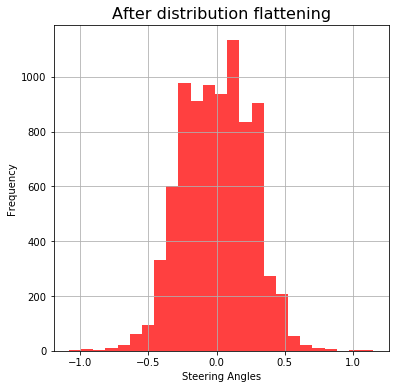

In [8]:
samples=newSamples
y_train = np.array([i[1] for i in samples])
plt.figure(figsize=(6,6))
plt.hist(y_train, bins, facecolor='r', alpha=0.75)
plt.title('After distribution flattening', fontsize=16)
plt.xlabel('Steering Angles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
## Set some parameters
newModel = True
modelFile = './udacityModel.h5'
colorSpace='RGB'
flipImagesLR = False


In [10]:
if newModel:
    print('Creating new model')
    model = smallerNVidiaModel()
#createNVidiaModel()
    model.compile(loss='mse', optimizer='adam')
else:
    print('Using old model from {}'.format(modelFile))
    model = load_model(modelFile)

Creating new model


/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu", strides=(1, 1), kernel_regularizer=<keras.reg...)`
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_laun

In [11]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator      = generator(train_samples,      dataDir, batch_size=32, color_space=colorSpace, useFlipImages=flipImagesLR)
validation_generator = generator(validation_samples, dataDir, batch_size=32, color_space=colorSpace, useFlipImages=flipImagesLR)

saveModelPerEpoch = ModelCheckpoint('udacityModel{epoch:02d}.h5')
numEpochsToTrain=20
history_object=model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=numEpochsToTrain, callbacks=[saveModelPerEpoch])
model.save(modelFile)



/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  if __name__ == '__main__':
/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=6704, epochs=20, validation_steps=1677)`
  if __name__ == '__main__':


Epoch 1/20
6704/6704 [==============================] - 554s - loss: 0.0612 - val_loss: 0.0387
Epoch 2/20
6704/6704 [==============================] - 547s - loss: 0.0258 - val_loss: 0.0421
Epoch 3/20
6704/6704 [==============================] - 546s - loss: 0.0248 - val_loss: 0.0561
Epoch 4/20
6704/6704 [==============================] - 550s - loss: 0.0260 - val_loss: 0.0420
Epoch 5/20
6704/6704 [==============================] - 550s - loss: 0.0256 - val_loss: 0.0354
Epoch 6/20
6704/6704 [==============================] - 550s - loss: 0.0258 - val_loss: 0.0360
Epoch 7/20
6704/6704 [==============================] - 551s - loss: 0.0251 - val_loss: 0.0337
Epoch 8/20
6704/6704 [==============================] - 550s - loss: 0.0260 - val_loss: 0.0349
Epoch 9/20
6704/6704 [==============================] - 549s - loss: 0.0254 - val_loss: 0.0355
Epoch 10/20
6704/6704 [==============================] - 547s - loss: 0.0264 - val_loss: 0.0349
Epoch 11/20
6704/6704 [==========================

## Learning graph

In [ ]:
# plot loss validation and training
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid(True)
plt.show()

print(model.summary())

## Run autonomously in simulator

In [13]:
%%capture
#runInSimCmd = 'drive.py {}'.format(modelFile)
%run -i drive.py udacityModel.h5